## Imports

In [21]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

## DataSet Download And Cleaning

In [22]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

sp500 = yf.download('^GSPC', start='2005-10-01', end='2025-10-01')

sp500.to_csv('sp500_20years.csv')

print(sp500.head())
print(f"\nTotal records: {len(sp500)}")

df = pd.read_csv('sp500_20years.csv', header=[0,1], index_col=0)

df.columns = df.columns.droplevel(1)
df = df.reset_index()
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df['Date'] = pd.to_datetime(df['Date'])

df.to_csv('sp500.csv', index=False)

print("Cleaned and saved!")
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2005-10-03  1226.699951  1233.339966  1225.150024  1228.810059  2097490000
2005-10-04  1214.469971  1229.880005  1214.020020  1226.699951  2341420000
2005-10-05  1196.390015  1214.469971  1196.250000  1214.469971  2546780000
2005-10-06  1191.489990  1202.140015  1181.920044  1196.390015  2792030000
2005-10-07  1195.900024  1199.709961  1191.459961  1191.489990  2126080000

Total records: 5030
Cleaned and saved!
        Date         Open         High          Low        Close      Volume
0 2005-10-03  1228.810059  1233.339966  1225.150024  1226.699951  2097490000
1 2005-10-04  1226.699951  1229.880005  1214.020020  1214.469971  2341420000
2 2005-10-05  1214.469971  1214.469971  1196.250000  1196.390015  2546780000
3 2005-10-06  1196.390015  1202.140015  1181.920044 

## Feature Engineering 

In [23]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

df = pd.read_csv('sp500.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Lagged Close(Previous day's close)
df['Close_lag1'] = df['Close'].shift(1)

# Daily Return(% change)
df['Daily_Return'] = df['Close'].pct_change() * 100

# Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# RSI(Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['BB_middle'] = df['Close'].rolling(window=20).mean()
bb_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
df['BB_width'] = df['BB_upper'] - df['BB_lower']

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_hist'] = df['MACD'] - df['MACD_signal']

# Average True Range (Volatility)
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR'] = true_range.rolling(window=14).mean()

# Target Variables
# Regression: Next day's Close
df['Next_Close'] = df['Close'].shift(-1)

# Classification: Spread Direction (1=Up, 0=Down)
df['Spread_Direction'] = (df['Next_Close'] > df['Close']).astype(int)

# Drop rows with NaN 
df = df.dropna().reset_index(drop=True)

print(f"Total features: {df.shape[1]}")
print(f"Total samples after cleaning: {df.shape[0]}")
df.head()

df.to_csv('sp500_features.csv', index=False)

Total features: 22
Total samples after cleaning: 4830


## Defining Features and Targtes 

In [24]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

feature_cols = ['Open', 'High', 'Low', 'Volume', 'Close_lag1', 'Daily_Return', 
                'SMA_20', 'SMA_50', 'SMA_200', 'RSI', 'BB_middle', 'BB_upper', 
                'BB_lower', 'BB_width', 'MACD', 'MACD_signal', 'MACD_hist', 'ATR']

X = df[feature_cols]
y_regression = df['Next_Close']
y_classification = df['Spread_Direction']

print(f"Features shape: {X.shape}")
print(f"Regression target shape: {y_regression.shape}")
print(f"Classification target shape: {y_classification.shape}")

Features shape: (4830, 18)
Regression target shape: (4830,)
Classification target shape: (4830,)


## Training and Test Data spllit

In [25]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

split_idx = int(len(df) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_reg_train, y_reg_test = y_regression[:split_idx], y_regression[split_idx:]
y_clf_train, y_clf_test = y_classification[:split_idx], y_classification[split_idx:]

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 3864
Test size: 966


## Feature Scaling

In [26]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation complete!")


Data preparation complete!


## Regression Model Training 

In [27]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

# Random Forest Regressor
print("Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_scaled, y_reg_train)
rf_reg_pred = rf_reg.predict(X_test_scaled)
print("Random Forest Regressor trained!")

# Gradient Boosting Regressor
print("\nTraining Gradient Boosting Regressor...")
gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_reg.fit(X_train_scaled, y_reg_train)
gb_reg_pred = gb_reg.predict(X_test_scaled)
print("Gradient Boosting Regressor trained!")

Training Random Forest Regressor...
Random Forest Regressor trained!

Training Gradient Boosting Regressor...
Gradient Boosting Regressor trained!


## Classification Model Training 

In [28]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

# Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_clf_train)
rf_clf_pred = rf_clf.predict(X_test_scaled)
print("Random Forest Classifier trained!")

# Gradient Boosting Classifier
print("\nTraining Gradient Boosting Classifier...")
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_scaled, y_clf_train)
gb_clf_pred = gb_clf.predict(X_test_scaled)
print("Gradient Boosting Classifier trained!")


Training Random Forest Classifier...
Random Forest Classifier trained!

Training Gradient Boosting Classifier...
Gradient Boosting Classifier trained!


## Regression Evaluation

In [29]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

print("REGRESSION MODELS EVALUATION (Price Prediction)")

# Random Forest Regressor
rf_rmse = np.sqrt(mean_squared_error(y_reg_test, rf_reg_pred))
rf_mae = mean_absolute_error(y_reg_test, rf_reg_pred)
rf_r2 = r2_score(y_reg_test, rf_reg_pred)

print("\n1. Random Forest Regressor:")
print(f"   RMSE: {rf_rmse:.4f}")
print(f"   MAE:  {rf_mae:.4f}")
print(f"   R²:   {rf_r2:.4f}")

# Gradient Boosting Regressor
gb_rmse = np.sqrt(mean_squared_error(y_reg_test, gb_reg_pred))
gb_mae = mean_absolute_error(y_reg_test, gb_reg_pred)
gb_r2 = r2_score(y_reg_test, gb_reg_pred)

print("\n2. Gradient Boosting Regressor:")
print(f"   RMSE: {gb_rmse:.4f}")
print(f"   MAE:  {gb_mae:.4f}")
print(f"   R²:   {gb_r2:.4f}")

REGRESSION MODELS EVALUATION (Price Prediction)

1. Random Forest Regressor:
   RMSE: 760.1332
   MAE:  502.5525
   R²:   0.1502

2. Gradient Boosting Regressor:
   RMSE: 760.5077
   MAE:  512.4818
   R²:   0.1494


## Classification Evaluation

In [30]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

print("CLASSIFICATION MODELS EVALUATION (Spread Direction)")

# Random Forest Classifier
rf_acc = accuracy_score(y_clf_test, rf_clf_pred)
rf_prec = precision_score(y_clf_test, rf_clf_pred)
rf_rec = recall_score(y_clf_test, rf_clf_pred)
rf_f1 = f1_score(y_clf_test, rf_clf_pred)

print("\n3. Random Forest Classifier:")
print(f"   Accuracy:  {rf_acc:.4f}")
print(f"   Precision: {rf_prec:.4f}")
print(f"   Recall:    {rf_rec:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")

# Gradient Boosting Classifier
gb_acc = accuracy_score(y_clf_test, gb_clf_pred)
gb_prec = precision_score(y_clf_test, gb_clf_pred)
gb_rec = recall_score(y_clf_test, gb_clf_pred)
gb_f1 = f1_score(y_clf_test, gb_clf_pred)

print("\n4. Gradient Boosting Classifier:")
print(f"   Accuracy:  {gb_acc:.4f}")
print(f"   Precision: {gb_prec:.4f}")
print(f"   Recall:    {gb_rec:.4f}")
print(f"   F1-Score:  {gb_f1:.4f}")

CLASSIFICATION MODELS EVALUATION (Spread Direction)

3. Random Forest Classifier:
   Accuracy:  0.4772
   Precision: 0.5045
   Recall:    0.3287
   F1-Score:  0.3981

4. Gradient Boosting Classifier:
   Accuracy:  0.4534
   Precision: 0.4740
   Recall:    0.3583
   F1-Score:  0.4081


## Confusion Matrices

In [31]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

print("CONFUSION MATRICES")

print("\nRandom Forest Classifier:")
print(confusion_matrix(y_clf_test, rf_clf_pred))

print("\nGradient Boosting Classifier:")
print(confusion_matrix(y_clf_test, gb_clf_pred))

CONFUSION MATRICES

Random Forest Classifier:
[[294 164]
 [341 167]]

Gradient Boosting Classifier:
[[256 202]
 [326 182]]


## Visualisations 

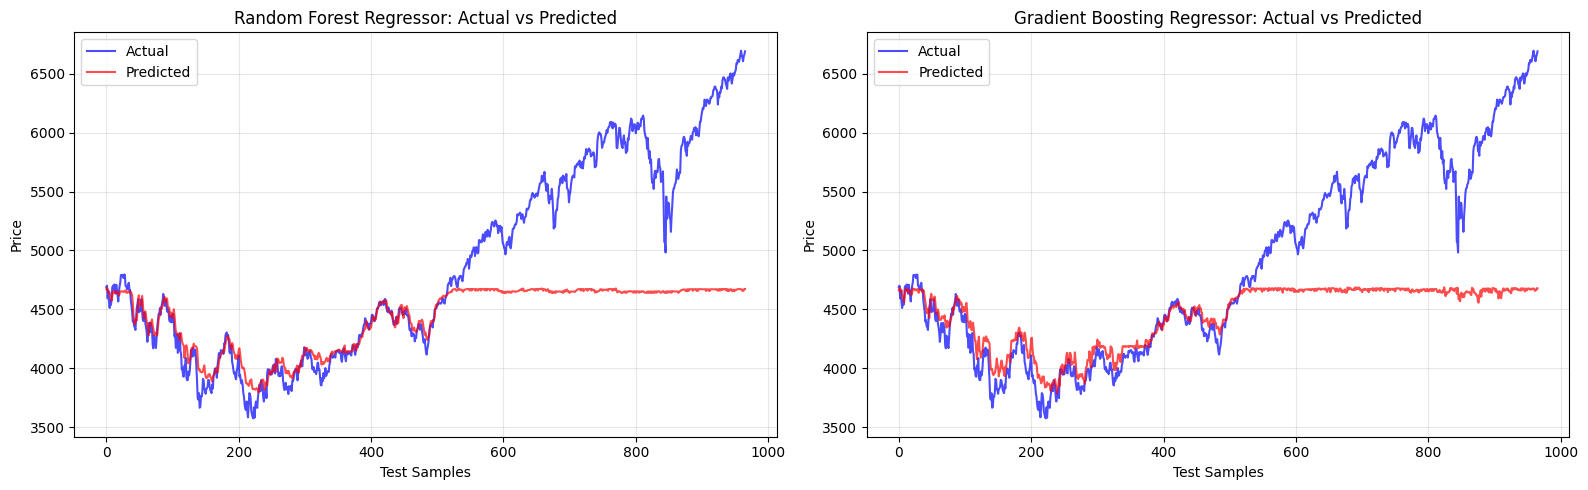

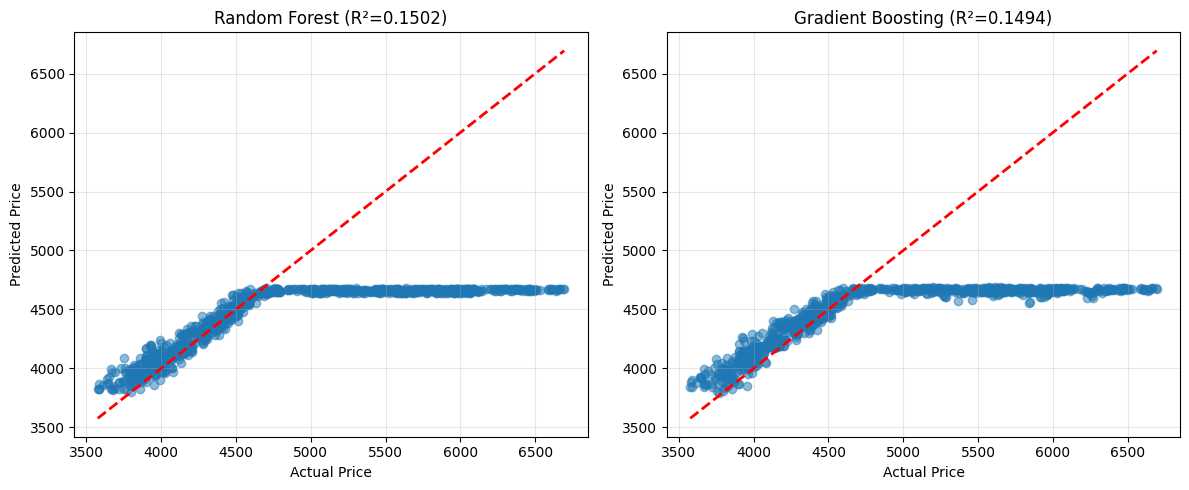

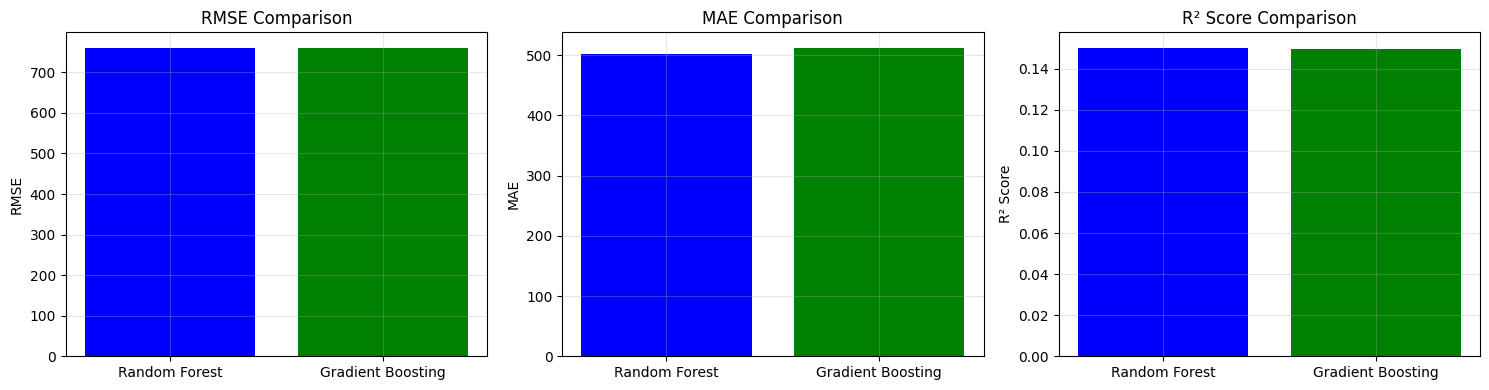

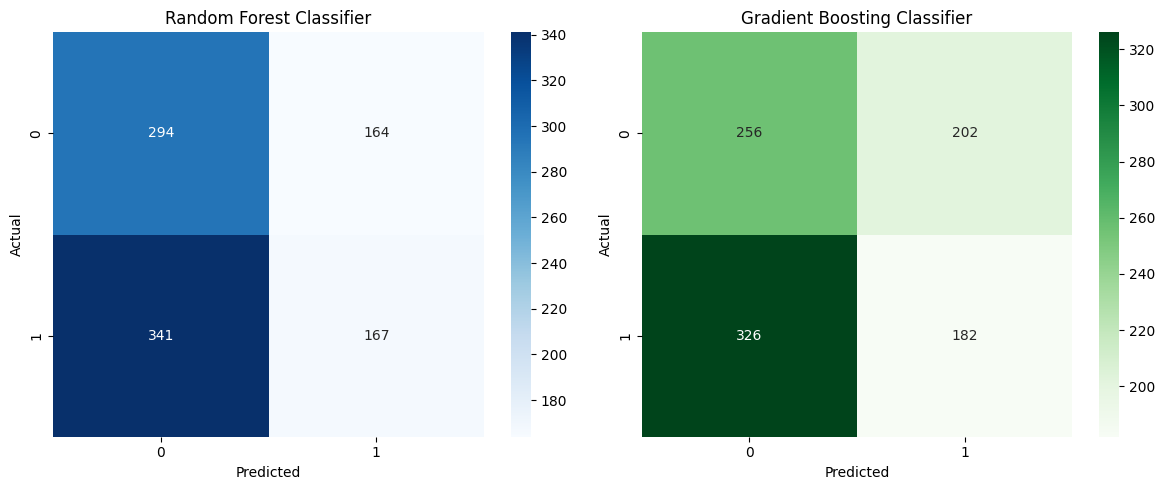

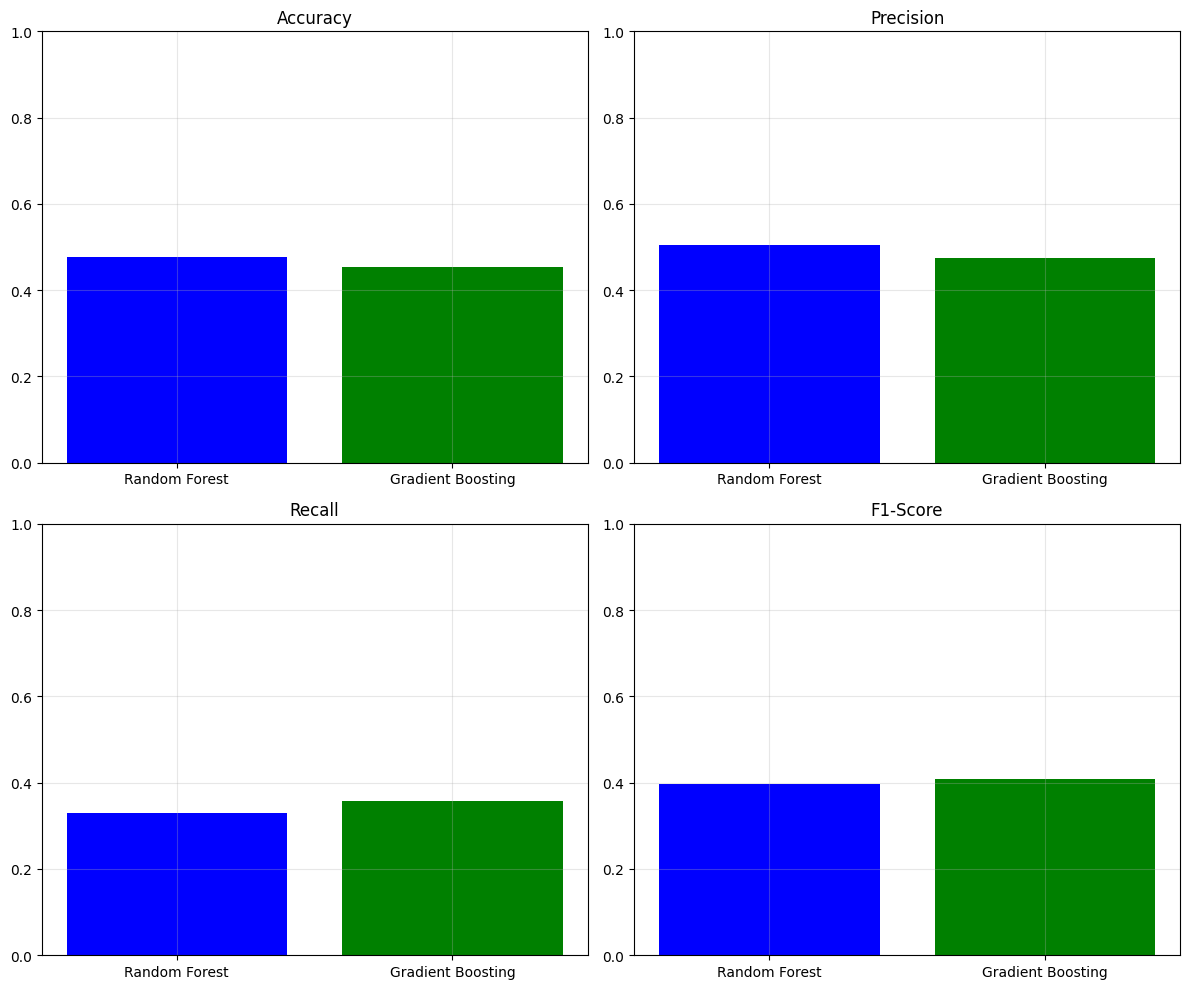

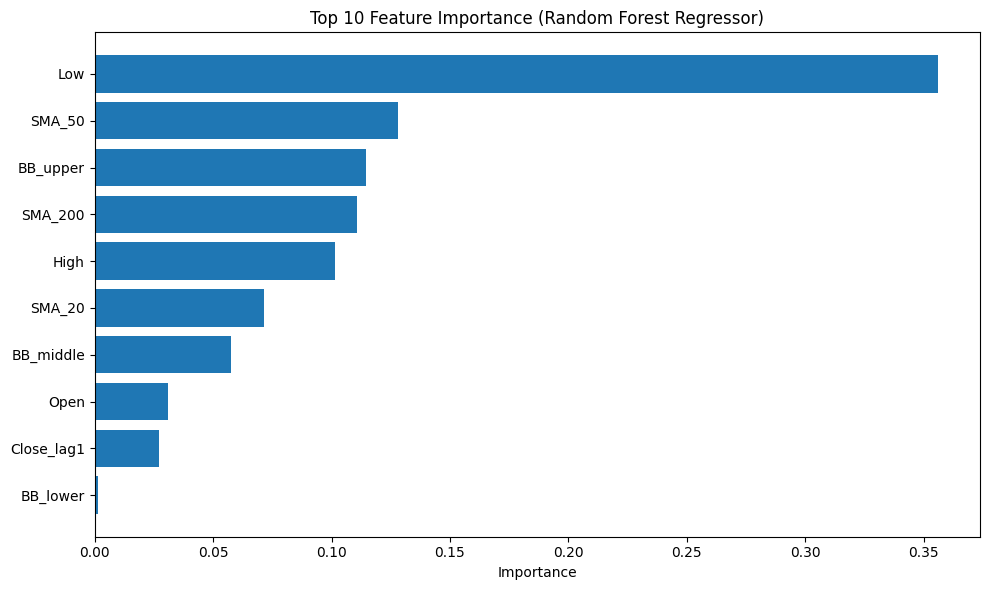

In [32]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

# REGRESSION: Actual vs Predicted Prices

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Random Forest
axes[0].plot(y_reg_test.values, label='Actual', color='blue', alpha=0.7)
axes[0].plot(rf_reg_pred, label='Predicted', color='red', alpha=0.7)
axes[0].set_title('Random Forest Regressor: Actual vs Predicted')
axes[0].set_xlabel('Test Samples')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gradient Boosting
axes[1].plot(y_reg_test.values, label='Actual', color='blue', alpha=0.7)
axes[1].plot(gb_reg_pred, label='Predicted', color='red', alpha=0.7)
axes[1].set_title('Gradient Boosting Regressor: Actual vs Predicted')
axes[1].set_xlabel('Test Samples')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# REGRESSION: Scatter Plot (Actual vs Predicted)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_reg_test, rf_reg_pred, alpha=0.5)
axes[0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[0].set_title(f'Random Forest (R²={rf_r2:.4f})')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_reg_test, gb_reg_pred, alpha=0.5)
axes[1].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
axes[1].set_title(f'Gradient Boosting (R²={gb_r2:.4f})')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# REGRESSION: Model Comparison Bar Chart

metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'RMSE': [rf_rmse, gb_rmse],
    'MAE': [rf_mae, gb_mae],
    'R²': [rf_r2, gb_r2]
})

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(metrics_df['Model'], metrics_df['RMSE'], color=['blue', 'green'])
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].grid(True, alpha=0.3)

axes[1].bar(metrics_df['Model'], metrics_df['MAE'], color=['blue', 'green'])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3)

axes[2].bar(metrics_df['Model'], metrics_df['R²'], color=['blue', 'green'])
axes[2].set_title('R² Score Comparison')
axes[2].set_ylabel('R² Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# CLASSIFICATION: Confusion Matrix Heatmaps

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_clf_test, rf_clf_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Classifier')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_clf_test, gb_clf_pred), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Gradient Boosting Classifier')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# CLASSIFICATION: Metrics Comparison

clf_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'Accuracy': [rf_acc, gb_acc],
    'Precision': [rf_prec, gb_prec],
    'Recall': [rf_rec, gb_rec],
    'F1-Score': [rf_f1, gb_f1]
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].bar(clf_metrics_df['Model'], clf_metrics_df['Accuracy'], color=['blue', 'green'])
axes[0,0].set_title('Accuracy')
axes[0,0].set_ylim([0, 1])
axes[0,0].grid(True, alpha=0.3)

axes[0,1].bar(clf_metrics_df['Model'], clf_metrics_df['Precision'], color=['blue', 'green'])
axes[0,1].set_title('Precision')
axes[0,1].set_ylim([0, 1])
axes[0,1].grid(True, alpha=0.3)

axes[1,0].bar(clf_metrics_df['Model'], clf_metrics_df['Recall'], color=['blue', 'green'])
axes[1,0].set_title('Recall')
axes[1,0].set_ylim([0, 1])
axes[1,0].grid(True, alpha=0.3)

axes[1,1].bar(clf_metrics_df['Model'], clf_metrics_df['F1-Score'], color=['blue', 'green'])
axes[1,1].set_title('F1-Score')
axes[1,1].set_ylim([0, 1])
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Feature Importance (Random Forest)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Random Forest Regressor)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Testing for Last Day

In [33]:
# Team ID : 8 ; Project ID : 8
# CHARAN M REDDY - PES2UG23CS146
# DILEEP - PES2UG23CS177

last_data = X_test_scaled[-1].reshape(1, -1)

predicted_price_rf = rf_reg.predict(last_data)[0]
predicted_price_gb = gb_reg.predict(last_data)[0]

predicted_direction_rf = rf_clf.predict(last_data)[0]
predicted_direction_gb = gb_clf.predict(last_data)[0]

print(f"Last date in test set: {df.iloc[split_idx + len(X_test) - 1]['Date']}")
print(f"\nRandom Forest predicted price: ${predicted_price_rf:.2f}")
print(f"Gradient Boosting predicted price: ${predicted_price_gb:.2f}")
print(f"\nRandom Forest direction: {'UP' if predicted_direction_rf == 1 else 'DOWN'}")
print(f"Gradient Boosting direction: {'UP' if predicted_direction_gb == 1 else 'DOWN'}")

Last date in test set: 2025-09-29 00:00:00

Random Forest predicted price: $4673.81
Gradient Boosting predicted price: $4678.88

Random Forest direction: DOWN
Gradient Boosting direction: DOWN
